In [83]:
import pandas as pd

def load_data(folder, start_idx_runs, n_runs, n_nodes):
    data = pd.read_csv('{}/evaluation_output.csv'.format(folder))
    data['run'] = start_idx_runs
    
    for i in range(1,n_runs):
        temp = pd.read_csv('{}/evaluation_output_{}.csv'.format(folder, i))
        temp['run'] = start_idx_runs+i
        data = data.append(temp)

    return data

n_runs = 10
n_nodes = 21

# load data where bad nodes sent a*c messages
data_ac = load_data('good20bad1C3', 0, 5, n_nodes)
data_ac['setting'] = 'ac'
# load data where bad nodes sent 1/2*a*c messages
data_05ac = load_data('good20bad1C3messages05', 6, 5, n_nodes)
data_05ac['setting'] = '05ac'

data = data_ac.append(data_05ac)

display(data)

,nodeId,roundId,good,seqNum,active,light,value,readyOut,run,setting
0,10,12,True,216,True,True,1,1,0,ac
1,6,12,True,217,True,True,1,1,0,ac
2,11,12,True,227,True,True,1,1,0,ac
3,5,12,True,215,True,True,1,1,0,ac
4,7,12,True,216,True,True,1,1,0,ac
...,...,...,...,...,...,...,...,...,...,...
16,20,12,True,278,True,True,1,1,10,05ac
17,19,12,True,106,False,True,1,1,10,05ac
18,6,12,True,264,True,True,1,1,10,05ac
19,13,12,True,279,True,True,1,1,10,05ac


In [91]:
def counts(data):
    counts = pd.DataFrame(range(n_runs), columns=['run'])
    # counting number of messages sent by good and bad nodes
    message_counts = data.groupby(['run', 'good'])['seqNum'].sum().reset_index()
    counts['count_bad'] = message_counts[message_counts['good'] == False]['seqNum'].values
    counts['count_good'] = message_counts[message_counts['good'] == True]['seqNum'].values
    counts['count'] = counts['count_bad'] + counts['count_good']
    
    # compute whether there is agreement
    agreement = data.groupby('run')['value'].nunique() == 1
    counts['agreement'] = agreement.values
    setting = data.groupby('run')['setting'].max()
    counts['setting'] = setting.values
    
    return counts

counts_data = counts(data)

display(counts_data)

,run,count_bad,count_good,count,agreement,setting
0,0,4310,3397,7707,False,ac
1,1,5652,4953,10605,True,ac
2,2,4973,4126,9099,False,ac
3,3,2264,2275,4539,False,ac
4,4,4926,3633,8559,True,ac
5,5,216,3627,3843,False,05ac
6,6,206,3376,3582,False,05ac
7,7,191,2914,3105,False,05ac
8,8,208,3635,3843,False,05ac
9,9,265,4676,4941,True,05ac


In [92]:
from scipy import stats

counts_data_ac = counts_data[counts_data['setting'] == 'ac']
counts_data_05ac = counts_data[counts_data['setting'] == '05ac']

print(stats.ttest_rel(counts_data_ac['count_good'], counts_data_ac['count_bad']))
print(stats.ttest_rel(counts_data_05ac['count_good'], counts_data_05ac['count_bad']))

Ttest_relResult(statistic=-3.5027445004160995, pvalue=0.024834376110279242)
Ttest_relResult(statistic=12.394729123779546, pvalue=0.00024355008862699193)


In [93]:
import numpy as np

def compute_complexity(counts):
    O = []
    
    # Compute the complexity limit for number of messages sent
    for _, run in counts.iterrows():
        T = min(n_nodes^2, run['count_bad'])
        O.append((T+n_nodes)*np.log(n_nodes))
        
    return O

O = compute_complexity(counts_data)

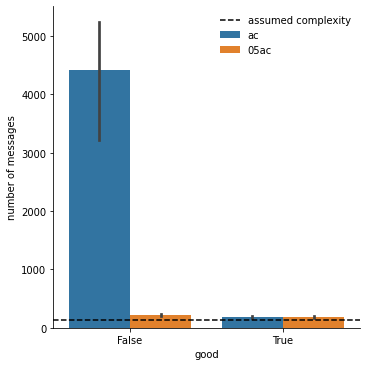

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(x='good', y='seqNum', kind='bar', hue='setting', data=data, legend=False)
plt.axhline(O[0], linestyle='--', color='k', label='assumed complexity')
plt.ylim(0)
plt.ylabel('number of messages')
plt.legend(frameon=False)

plt.show()

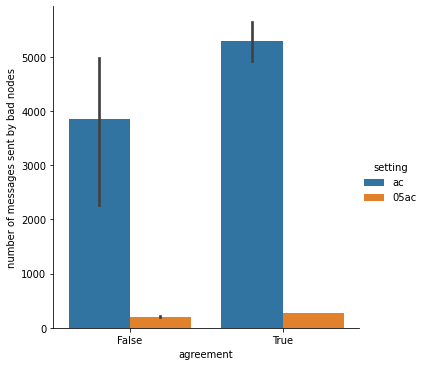

In [124]:
sns.catplot(x='agreement', y='count_bad', kind='bar', hue='setting', data=counts_data)
plt.ylim(0)
plt.ylabel('number of messages sent by bad nodes')
plt.show()

In [122]:
from scipy.stats import pearsonr

corr_ac, _ = pearsonr(counts_data_ac['count_bad'], counts_data_ac['agreement'])
corr_05ac, _ = pearsonr(counts_data_05ac['count_bad'], counts_data_05ac['agreement'])
print(corr)
print(corr_05ac)

0.6076084587410279
0.9472796953190514
